In [1]:
# PLOT VON DEN VEKTORFELDERN #
# !!!!!!!!!!!!!!!! ACHTUNG !!!!!!!!!! #
# get_trajectory entspricht nicht mehr dem aus dem caging_pattern.py, dort ist es jetzt zeitabhängig #


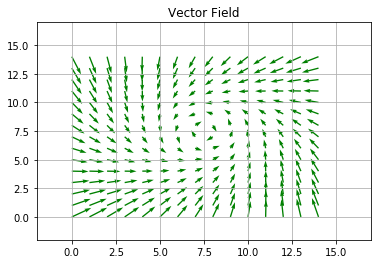

In [5]:
import numpy as np
import numdifftools as nd
import matplotlib.pyplot as plt

def sigma_plus(omega):
    return (1 / (1 + np.exp(1 - omega)))


def sigma_minus(omega):
    return 1 / (1 + np.exp(omega - 1))


def f(N):
#     print("\n f(", N, ")=", sigma_plus(N))
    return sigma_plus(N)


def g(T):
#     print("\n g(", T, ")=", 1 - sigma_minus(T))
    return 1 - sigma_minus(T)


def s(x, y, r, center):
    """
    Signed distance function for a circle with center (cx, cy) and radius r.
    Returns a 2D array of signed distances, evaluated at the points (x, y).
    """
    cx = center[0]
    cy = center[1]
    
    # Compute the Euclidean distance between each point (x,y) and the center (cx,cy)
    d = np.sqrt((x - cx)**2 + (y - cy)**2)
    
    # Compute the signed distance function
    s = d - r
    
    # Set the value to zero exactly on the circle boundary
    s = np.where(np.isclose(np.abs(s), 0.0), 0.0, s)
    
    # Set the value to negative inside the circle
    s[d < r] = -s[d < r]
    
    return s

def get_trajectory(start, goal, distance):
    # Calculate the vector from start to goal
    vector = np.array(goal) - np.array(start)

    # Calculate the length of the vector
    length = np.linalg.norm(vector)

    # Calculate the unit vector in the direction of the vector
    unit_vector = vector / length

    # Calculate the scaled vector with length equal to `distance`
    scaled_vector = distance * unit_vector

    # Calculate the final point by adding the scaled vector to the start point
    point = np.array(start) + scaled_vector

    return tuple(point)


class Control:
    def __init__(self):
        self.state = "SURROUND"
        self.goal_position = [5.0, 5.0]
        self.Q  =  [[0.0, 0.0]]
        self.beta_0 = 0.0
        self.r = 0.22
        self.R = 3.0
        self.current_object_center = [10.0, 10.0]# np.array([[0, 0]]).T
    
    def shape_control(self, K, q, object_center):
#         print("\n shape_control(", K, ")")
        # K controls the rate of descent to the specified surface relative the orbiting velocity
        # and is used to help generate different behaviors
        self.Q = q
        
        self.beta_0 = self.R - np.linalg.norm(self.Q)
        self.current_object_center = object_center
        dx = q[0][0] - self.current_object_center[0]
        dy = q[0][1] - self.current_object_center[1]
        theta = np.arctan2(dy, dx)
        
        vector = [np.cos(theta) * self.gamma(q[0]), np.sin(theta) * self.gamma(q[0])]
#         vector = nd.Gradient(self.phi)(q[0])
    
        minute = np.multiply(np.multiply(-1.0 * K, f(self.N())), np.array(vector))
        subtrahend = np.multiply(self.gradient_cross_psi(q[0]), g(self.T()))
#         print("\n nd.Gradient(self.phi)(q[0])", nd.Gradient(self.phi)(q[0]))
#         print("minute", minute)
#         print("subtrahend", subtrahend)
        u = np.subtract(minute, subtrahend)
        return u
    
    def gradient_cross_psi(self, q):
        matrix_3x3 = np.cross(nd.Gradient(self.psi)(q), np.array([1, 1, 1]))
        vector_2d = np.array([matrix_3x3[2][0], matrix_3x3[2][1]])
#         print("\n gradient_cross_psi(", q, ")=", vector_2d)
#         print("psi=", self.psi(q))
        return vector_2d
        
    
    def get_r_cage(self):
        return 1.52925 # 0.5 * self.d_max + self.r + self.l + self.e
    
    def gamma(self, q): 
        if self.state == "TRANSPORT":
            center = get_trajectory(self.current_object_center, self.goal_position, 0.5)
            return s(q[0], q[1], self.get_r_cage(), center)
        else:
            return s(q[0], q[1], self.get_r_cage(), self.current_object_center)

    def phi(self, q):
        gamma_q = self.gamma(q)
        return gamma_q ** 2 / (gamma_q ** 2 + self.beta_0)

    def psi(self, q):
        return np.array([[0.0, 0.0, self.gamma(q)]]).T

    def t(self, j, k):
#         print("\n t(j,k)", j, k)
        q = self.Q
        
        multiplier_1 = np.subtract(q[0], q[j]).T
        multiplier_2 = np.multiply(self.gradient_cross_psi(q[j]), -1)
        numerator = np.multiply(multiplier_1, multiplier_2)
        
#         print("multiplier_1", multiplier_1)
#         print("multiplier_2", multiplier_2)
#         print("numerator", numerator)
        
        minute = np.linalg.norm(np.subtract(q[0], q[j]), ord=k)
        subtrahend = np.power((2 * self.r), k)
        denominator = np.subtract(minute, subtrahend)
        
#         print("minute", minute)
#         print("subtrahend", subtrahend)
#         print("denominator", denominator)
        
#         print("t(", j, k, ")=", np.divide(numerator, denominator))
        
        return np.divide(numerator, denominator)

    def n(self, j, k):
#         print("\n n(j,k)", j, k)
        q = self.Q
        
        multiplier_1 = np.subtract(q[0], q[j]).T
        multiplier_2 = np.multiply(nd.Gradient(self.phi)(q[j]), -1)
        numerator = np.multiply(multiplier_1, multiplier_2)
        
#         print("multiplier_1", multiplier_1)
#         print("multiplier_2", multiplier_2)
#         print("numerator", numerator)
        
        minute = np.linalg.norm(np.subtract(q[0], q[j]), ord=k)
        subtrahend = np.power((2 * self.r), k)
        denominator = np.subtract(minute, subtrahend)
        
#         print("minute", minute)
#         print("subtrahend", subtrahend)
#         print("denominator", denominator)
        
#         print("n(", j, k, ")=", np.divide(numerator, denominator))
        
        return np.divide(numerator, denominator)

    def T(self):
#         print("\n T")
        q = self.Q
        result = np.array([0.0, 0.0])
        for j in range(1, len(q)):
            numerator = sigma_plus(self.t(j, 2))
            denominator = np.linalg.norm(np.subtract(q[0], q[j]), ord=2) - ((2 * self.r) ** 2)
            minute = np.divide(numerator, denominator)
            
#             print("numerator", numerator)
#             print("denominator", denominator)
#             print("minute", minute)
            
            numerator = sigma_minus(self.t(j, 4))
            denominator = np.linalg.norm(np.subtract(q[0], q[j]), ord=4) - ((2 * self.r) ** 4)
            subtrahend = np.divide(numerator, denominator)
            
#             print("numerator", numerator)
#             print("denominator", denominator)
#             print("subtrahend", subtrahend)
            
#             print("subtract", np.subtract(minute, subtrahend))
            
            result += np.subtract(minute, subtrahend)
#         print("T=", result)
        return result

    def N(self):
#         print("\n N")
        q = self.Q
        result = np.array([0.0, 0.0])
        for j in range(1, len(q)):
            numerator = sigma_plus(self.n(j, 2))
            denominator = np.linalg.norm(np.subtract(q[0], q[j]), ord=2) - ((2 * self.r) ** 2)
            minute = np.divide(numerator, denominator)
            
#             print("numerator", numerator)
#             print("denominator", denominator)
#             print("minute", minute)
            
            numerator = sigma_minus(self.n(j, 4))
            denominator = np.linalg.norm(np.subtract(q[0], q[j]), ord=4) - ((2 * self.r) ** 4)
            subtrahend = np.divide(numerator, denominator)
            
#             print("numerator", numerator)
#             print("denominator", denominator)
#             print("subtrahend", subtrahend)
            
#             print("subtract", np.subtract(minute, subtrahend))
            
            result += np.subtract(minute, subtrahend)
#         print("N=", result)
        return result

            
    
        start = self.current_object_center
        goal = goal_pos
        distance = 0.1
        
        # Calculate the vector from start to goal
        vector = np.array(goal) - np.array(start)

        # Calculate the length of the vector
        length = np.linalg.norm(vector)

        # Calculate the unit vector in the direction of the vector
        unit_vector = vector / length

        # Calculate the scaled vector with length equal to `distance`
        scaled_vector = distance * unit_vector

        # Calculate the final point by adding the scaled vector to the start point
        point = np.array(start) + scaled_vector

        return tuple(point)
#             return -x, -y

controller = Control()
k = 0.3
size = 15
object_center = [float(size / 2), float(size / 2)]
x = []
y = []
u = []
v = []

# ,[2.0,2.0],[1.0,4.0],[6.0,2.0],[12.0,12.0]

for x_i in range(0, size):
    for y_i in range(0, size):
        result = controller.shape_control(k, [[float(x_i), float(y_i)]], object_center)
        x.append(x_i)
        y.append(y_i)
        u.append(result[0])
        v.append(result[1])

# Plotting Vector Field with quiver() function
plt.quiver(x, y, u, v, color='g')
plt.title('Vector Field')

# Setting boundary limits
plt.xlim(-2, size + 2)
plt.ylim(-2, size + 2)

# Show plot with grid
plt.grid()
plt.show()

(7.468377223398316, 7.594868329805052)


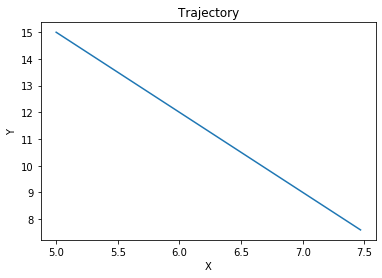

In [3]:
def get_trajectory(start, goal, distance): 
        # Calculate the vector from start to goal
        vector = np.array(goal) - np.array(start)

        # Calculate the length of the vector
        length = np.linalg.norm(vector)

        # Calculate the unit vector in the direction of the vector
        unit_vector = vector / length

        # Calculate the scaled vector with length equal to `distance`
        scaled_vector = distance * unit_vector

        # Calculate the final point by adding the scaled vector to the start point
        point = np.array(start) + scaled_vector

        return tuple(point)
    
# Define start and goal points
start = object_center
goal = [5.0, 15.0]
distance = 0.1

# Generate the trajectory
trajectory = []
current_point = start
print(get_trajectory(current_point, goal, distance))
while np.linalg.norm(np.array(current_point) - np.array(goal)) > distance:
    current_point = get_trajectory(current_point, goal, distance)
    trajectory.append(current_point)

# Add the final goal point to the trajectory
trajectory.append(goal)

# Plot the trajectory
x_values = [point[0] for point in trajectory]
y_values = [point[1] for point in trajectory]
plt.plot(x_values, y_values)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Trajectory')
plt.show()

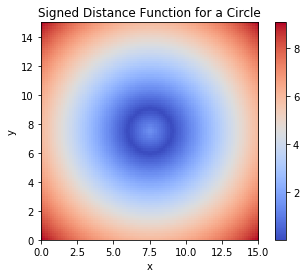

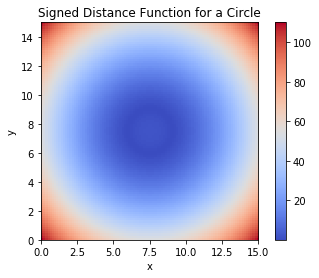

In [4]:
import numpy as np

def s(x, y, r, center):
    """
    Signed distance function for a circle with center (cx, cy) and radius r.
    Returns a 2D array of signed distances, evaluated at the points (x, y).
    """
    cx = center[0]
    cy = center[1]
    
    # Compute the Euclidean distance between each point (x,y) and the center (cx,cy)
    d = np.sqrt((x - cx)**2 + (y - cy)**2)
    
    # Compute the signed distance function
    s = d - r
    
#     # Set the value to zero exactly on the circle boundary
#     s = np.where(np.isclose(np.abs(s), 0.0), 0.0, s)
    
#     # Set the value to zero exactly on the circle boundary
#     s[np.abs(s) < 1e-12] = 0.0

#     # Set the value to negative inside the circle
#     s = np.where(s < 0, -np.abs(s), s)
    
    # Set the value to negative inside the circle
    s[d < r] = -s[d < r]
    
    return s

def s_2(x, y, r_cage, center):
    # s(x, y) = 0 with s(x, y) < 0 for (x, y) inside ∂S and s(x, y) > 0 for (x, y) outside ∂S
    circle_function = (x - center[0]) ** 2 + (y - center[1]) ** 2
    result = circle_function - r_cage ** 2
    for i in range(len(circle_function)):
        for j in range(len(circle_function)):
            if circle_function[i][j] - r_cage ** 2 < 0:
                result[i][j] = -result[i][j]
    return result

# Define the circle center and radius
cx = float(size / 2)
cy = float(size / 2)
r = 1.52925

# Define the x and y ranges
x_range = np.linspace(0, size, 100)
y_range = np.linspace(0, size, 100)

# Create a grid of points (x,y)
X, Y = np.meshgrid(x_range, y_range)

# Evaluate the signed distance function at each point
S = s(X, Y, r, object_center)

# Plot the signed distance function
plt.imshow(S, origin='lower', extent=(0, size, 0, size), cmap='coolwarm')
plt.colorbar()
plt.title('Signed Distance Function for a Circle')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Evaluate the signed distance function at each point
S = s_2(X, Y, r, object_center)

# Plot the signed distance function
plt.imshow(S, origin='lower', extent=(0, size, 0, size), cmap='coolwarm')
plt.colorbar()
plt.title('Signed Distance Function for a Circle')
plt.xlabel('x')
plt.ylabel('y')
plt.show()
